# Alphas Plots for Regularized Regression

This is a development notebook to explore the use of alpha plots for regularized regression.

In [1]:
%matplotlib inline

In [2]:
import os 
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")
import yellowbrick as yb

## Data Loading

In [3]:
## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "..", "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
}


def load_data(name):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
        
    
    # Return the data frame
    return pd.read_csv(path)

In [4]:
# Load the data
df = load_data('concrete')
feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
target_name = 'strength'

# Get the X and y data from the DataFrame 
X = df[feature_names].as_matrix()
y = df[target_name].as_matrix() 

### Alphas Configuration

In [5]:
# Set the alphas 
alphas = np.logspace(-10, 0, 400)

## Visualizers 

In [6]:
from yellowbrick.regressor import AlphaSelection 
from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV, ElasticNetCV

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


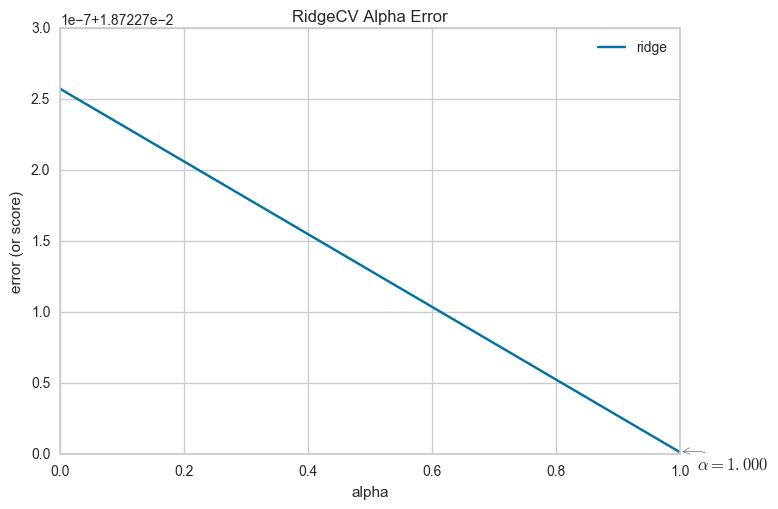

In [7]:
model = AlphaSelection(RidgeCV(alphas=alphas, scoring="neg_mean_squared_error"))
model.fit(X, y)
model.poof()

In [ ]:
model = AlphaSelection(LassoCV(alphas=alphas))
model.fit(X, y)
model.poof()

In [ ]:
model = AlphaSelection(LassoLarsCV())
model.fit(X, y)
model.poof()

In [ ]:
model = AlphaSelection(ElasticNetCV())
model.fit(X, y)
model.poof()

## Ridge Regularization

### Manual Ridge 

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

errors = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X, y, cv=12, scoring='neg_mean_squared_error')
    errors.append(score.mean())

plt.plot(alphas, errors, label='ridge')
plt.xlabel('alpha')
plt.ylabel('mean squared error')
plt.title("Manual Ridge Alpha Scoring")
plt.show()

## Ridge CV

In [ ]:
from sklearn.linear_model import RidgeCV 

# Must pass store_cv_values=True in order to store the MSE of the alphas. 
ridge = RidgeCV(alphas=alphas, store_cv_values=True, scoring='neg_mean_squared_error')
ridge.fit(X, y)

# cv_values_ : array, shape = [n_samples, n_alphas] or shape = [n_samples, n_targets, n_alphas], optional
# Cross-validation values for each alpha (if store_cv_values=True and cv=None). 
# After fit() has been called, this attribute will contain the mean squared errors (by default) or the 
# values of the {loss,score}_func function (if provided in the constructor).
ridge.cv_values_.mean(0)

g = plt.plot(ridge.alphas, ridge.cv_values_.mean(0), label="ridge")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("RidgeCV Alapha Error")
plt.show()

In [ ]:
ridge.alpha_

## LASSO Regularization 

### Lasso CV

In [ ]:
from sklearn.linear_model import LassoCV 

lasso = LassoCV(alphas=alphas)
lasso.fit(X, y)

# mse_path_ : array, shape (n_l1_ratio, n_alpha, n_folds)
# Mean square error for the test set on each fold, varying l1_ratio and alpha.

g = plt.plot(lasso.alphas_, lasso.mse_path_.mean(1), label="lasso")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("LassoCV Alapha Error")
plt.show()

In [ ]:
lasso.alpha_

### Lasso LARS CV

In [ ]:
from sklearn.linear_model import LassoLarsCV 

larslasso = LassoLarsCV()
larslasso.fit(X, y)

# mse_path_ : array, shape (n_l1_ratio, n_alpha, n_folds)
# Mean square error for the test set on each fold, varying l1_ratio and alpha.

g = plt.plot(larslasso.cv_alphas_, larslasso.cv_mse_path_.mean(1), label="lasso lars")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("LassoLarsCV Alapha Error")
plt.show()

In [ ]:
larslasso.alpha_

## ElasticNet Regularization

In [ ]:
from sklearn.linear_model import ElasticNetCV 

enet = ElasticNetCV(alphas=alphas)
enet.fit(X, y)

g = plt.plot(enet.alphas_, enet.mse_path_.mean(1), label="elasticnet")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("ElasticNetCV Alapha Error")
plt.show()

In [ ]:
enet.alpha_

## Plot All 

In [ ]:
# Plot all 
plt.plot(ridge.alphas, ridge.cv_values_.mean(0), label="ridge")
plt.plot(lasso.alphas_, lasso.mse_path_.mean(1), label="lasso")
# plt.plot(larslasso.cv_alphas_, larslasso.cv_mse_path_.mean(1), label="lasso lars")
plt.plot(enet.alphas_, enet.mse_path_.mean(1), label="elasticnet")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("Regression CV Alapha Error")
plt.legend(loc='best')
plt.show()

## Plot Ridge Coefficients against Alpha 

This sample code comes from the [Scikit-Learn documentation](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html). Just an interesting different take on this to see if we can make a visualizer from it. 

In [ ]:
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

clf = Ridge()

# To do this, you need to know the true function defined by w. 
X, y, w = make_regression(n_samples=10, n_features=10, coef=True,
                          random_state=1, bias=3.5)

coefs = []
errors = []

alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    errors.append(mean_squared_error(clf.coef_, w))

# Display results
plt.figure(figsize=(20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

# This plot is similar to the plots we did above. 
plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularization')
plt.axis('tight')

plt.show()